In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import MinMaxScaler

### TODO:
- group by addresses first and p_lat, p_lng second by choosing a radius to cluster p_lat, p_lng into groups
- invistigate phone calls, and reasons: compare reasons for better vs worse HO. Check most common phone_calls_reasons when performance is worse.
- `do we need to recalc avg and median for last 3 months??`
- `do we need to get other data for the last 3 months to compare?? like:`
    - phone calls reasons: look for emerging or diminished reasons
    - should we only consider data points with a similar timeframe, compare after PE with before on the same day, and hour??
    - p2a: when providing a parking location, the driver might choose a different road to get to that parking
        - shouldn't be of concern to us; not the scope of the problem?
- `do we need other data in general?`
    - drivers data like has he been to that address before
    - more data points because currently the data is skewed, is it always skewed or is it only for these 3 months?
        - `actually should check the avg and median values first`
- `we do need drivers' data to group by drivers`

# 1. Prepare Data

In [2]:
tasks = pd.read_csv('task_data.csv', index_col=0)
tasks

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,f0_,p_lat,...,median_handover_last_3_months,better_avg ?,diff,should_skip,why ?,is_parking_accurate (manual field),time in dubai,hour,day,is_weekend
id_task,,,,,,,,,,,,,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area",25.200012,...,208.0,False,-40.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin...",NaN,...,111.0,False,-28.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are...",NaN,...,106.0,False,-129.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli...",NaN,...,379.0,False,-229.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e...",NaN,...,378.0,False,-210.0,NaN,NaN,NaN,NaN,0.0,30.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin",NaN,...,574.0,False,-253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin",NaN,...,111.0,False,-37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin",NaN,...,309.0,True,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
tasks.drop(columns=['p_lat', 'p_lng', 'should_skip', 'why ?', 'is_parking_accurate (manual field)', # null cols
                    'time in dubai', 'hour', 'day', 'is_weekend', # null cols
                    'median_handover_last_3_months', 'better_avg ?', 'diff'], inplace=True) # not accurate cols

tasks.rename(columns={'f0_': 'phone_calls_reasons'}, inplace=True)
tasks

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,phone_calls_reasons
id_task,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area"
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin..."
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are..."
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli..."
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e..."
...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin"
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin"
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin"


In [4]:
addresses = pd.read_csv('address_data.csv', index_col=0)
addresses

,p_lat,p_lng,avg_handover_last_3_months,median_handover_last_3_months
dst_address_code,,,,
addr::noon_customer::ae::007a4e3a2c44fbaa079ea59a86a510ee::1,25.173479,55.301138,150.121212,113.0
addr::noon_customer::ae::022bb91787140e12518fe7dd5e1c781a::3,25.172925,55.306330,155.816667,133.5
addr::noon_customer::ae::02e5512d32d4d45ab84b68c50c8a0508::1,25.172434,55.301876,201.000000,180.5
addr::noon_customer::ae::03224d21fd7ba1ddeac9c1b18c471eb4::2,25.187410,55.267974,387.818182,387.0
addr::noon_customer::ae::00d99be27c4705216fbf507600a4756a::4,25.182195,55.255434,533.266667,420.0
...,...,...,...,...
addr::noon_customer::ae::fd8be86d1af247690f3bb17ce7b5e7ac::2,25.188033,55.269899,361.833333,364.0
addr::noon_customer::ae::fe21ca84a1e471264fc8ad3c53b2bb54::3,25.211140,55.276156,321.612903,268.0
addr::noon_customer::ae::fee90d758a4911b100376c9782048b2a::2,25.208492,55.274248,222.260000,168.0


In [5]:
addresses.rename(columns={'avg_handover_last_3_months': 'avg_address_handover_last_3_months', 
                          'median_handover_last_3_months': 'median_address_handover_last_3_months'}, inplace=True)
addresses

,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months
dst_address_code,,,,
addr::noon_customer::ae::007a4e3a2c44fbaa079ea59a86a510ee::1,25.173479,55.301138,150.121212,113.0
addr::noon_customer::ae::022bb91787140e12518fe7dd5e1c781a::3,25.172925,55.306330,155.816667,133.5
addr::noon_customer::ae::02e5512d32d4d45ab84b68c50c8a0508::1,25.172434,55.301876,201.000000,180.5
addr::noon_customer::ae::03224d21fd7ba1ddeac9c1b18c471eb4::2,25.187410,55.267974,387.818182,387.0
addr::noon_customer::ae::00d99be27c4705216fbf507600a4756a::4,25.182195,55.255434,533.266667,420.0
...,...,...,...,...
addr::noon_customer::ae::fd8be86d1af247690f3bb17ce7b5e7ac::2,25.188033,55.269899,361.833333,364.0
addr::noon_customer::ae::fe21ca84a1e471264fc8ad3c53b2bb54::3,25.211140,55.276156,321.612903,268.0
addr::noon_customer::ae::fee90d758a4911b100376c9782048b2a::2,25.208492,55.274248,222.260000,168.0


In [6]:
test_data = tasks.join(addresses, on='dst_address_code', how='inner')
test_data

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,phone_calls_reasons,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months
id_task,,,,,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area",25.200012,55.273745,272.058824,208.0
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin...",25.180109,55.276237,126.978723,111.0
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are...",25.192179,55.277676,129.084746,106.0
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli...",25.180929,55.263000,439.513513,379.0
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e...",25.190008,55.263444,382.125000,378.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin",25.180975,55.253404,517.800000,574.0
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin",25.176177,55.250870,152.148148,111.0
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin",25.191212,55.281648,335.142857,309.0


# 2. Analyze Data

In [7]:
(test_data['o2a_time_seconds'] > test_data['p2a_time_seconds']+60).value_counts()

True     5416
False       2
Name: count, dtype: int64

In [8]:
test_data.columns

Index(['created_at', 'mp_Task_nr', 'handover_time_seconds', 'o2a_time_seconds',
       'p2a_time_seconds', 'phone_calls', 'dst_address_code', 'fleets',
       'phone_calls_reasons', 'p_lat', 'p_lng',
       'avg_address_handover_last_3_months',
       'median_address_handover_last_3_months'],
      dtype='object')

In [9]:
test_data['reversed_deviation'] = test_data['avg_address_handover_last_3_months'] - test_data['handover_time_seconds']
test_data['reversed_median_deviation'] = test_data['median_address_handover_last_3_months'] - test_data['handover_time_seconds']
test_data['better_than_avg'] = test_data['reversed_deviation'] > 0
test_data['better_than_median'] = test_data['reversed_median_deviation'] > 0
test_data['dubai_time'] = pd.to_datetime(test_data['created_at']) + pd.Timedelta(hours=4)
test_data['day'] = test_data['dubai_time'].dt.day
test_data['hour'] = test_data['dubai_time'].dt.hour
test_data

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,phone_calls_reasons,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months,reversed_deviation,reversed_median_deviation,better_than_avg,better_than_median,dubai_time,day,hour
id_task,,,,,,,,,,,,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area",25.200012,55.273745,272.058824,208.0,24.058824,-40.0,True,False,2025-03-13 11:15:10+00:00,13,11
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin...",25.180109,55.276237,126.978723,111.0,-12.021277,-28.0,False,False,2025-03-15 19:17:21+00:00,15,19
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are...",25.192179,55.277676,129.084746,106.0,-105.915254,-129.0,False,False,2025-03-17 15:44:00+00:00,17,15
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli...",25.180929,55.263000,439.513513,379.0,-168.486487,-229.0,False,False,2025-03-17 13:58:09+00:00,17,13
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e...",25.190008,55.263444,382.125000,378.0,-205.875000,-210.0,False,False,2025-03-13 08:12:18+00:00,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin",25.180975,55.253404,517.800000,574.0,-309.200000,-253.0,False,False,2025-03-13 14:01:22+00:00,13,14
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin",25.176177,55.250870,152.148148,111.0,4.148148,-37.0,True,False,2025-03-16 02:58:19+00:00,16,2
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin",25.191212,55.281648,335.142857,309.0,40.142857,14.0,True,True,2025-03-14 16:05:02+00:00,14,16


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5418 entries, 60148579 to 60157401
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   created_at                             5418 non-null   object             
 1   mp_Task_nr                             5418 non-null   object             
 2   handover_time_seconds                  5418 non-null   int64              
 3   o2a_time_seconds                       5418 non-null   int64              
 4   p2a_time_seconds                       5418 non-null   int64              
 5   phone_calls                            5418 non-null   int64              
 6   dst_address_code                       5418 non-null   object             
 7   fleets                                 5389 non-null   object             
 8   phone_calls_reasons                    2439 non-null   object             
 9   p_

In [11]:
test_data['created_at'] = pd.to_datetime(test_data['created_at'])
test_data = test_data.dropna(subset=['fleets'])

In [12]:
test_data.describe()

,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months,reversed_deviation,reversed_median_deviation,day,hour
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000
mean,266.884394,2221.545927,1157.703284,1.174986,25.188034,55.274912,279.774022,248.348766,12.889628,-18.535628,15.136946,14.492856
std,228.695691,756.981339,499.706181,1.557604,0.016885,0.015261,113.747936,108.638748,222.273269,222.107592,1.496403,5.798858
min,3.000000,379.000000,26.000000,0.000000,25.090769,55.228009,13.733333,4.000000,-2723.500000,-2742.500000,12.000000,0.000000
25%,134.000000,1703.000000,817.000000,0.000000,25.180975,55.265626,197.555556,172.000000,-40.347826,-70.000000,14.000000,12.000000
50%,212.000000,2134.000000,1094.000000,0.000000,25.188968,55.272847,261.666667,226.500000,44.542857,16.000000,15.000000,15.000000
75%,332.000000,2616.000000,1401.000000,2.000000,25.194714,55.281758,343.086956,309.000000,119.025000,86.500000,16.000000,19.000000
max,2879.000000,7099.000000,4342.000000,36.000000,25.211409,55.309227,1000.000000,1000.000000,891.000000,891.000000,18.000000,23.000000


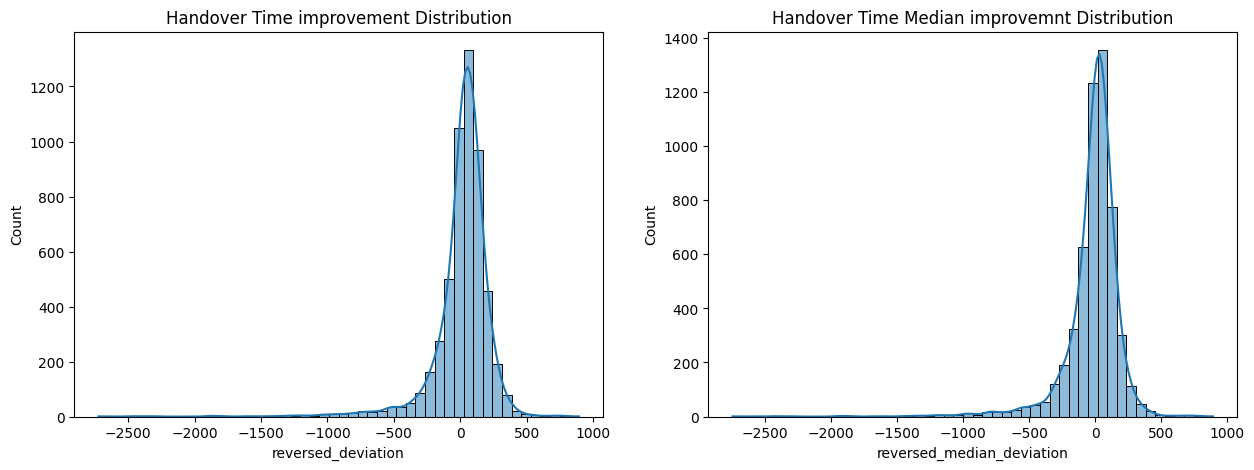

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(test_data['reversed_deviation'], bins=50, kde=True)
plt.title('Handover Time improvement Distribution')
plt.subplot(1, 2, 2)
sns.histplot(test_data['reversed_median_deviation'], bins=50, kde=True)
plt.title('Handover Time Median improvemnt Distribution')
plt.show()

In [14]:
print(f'orders bettwr than average: {test_data['better_than_avg'].mean()*100}%')
print(f'orders bettwr than median: {test_data['better_than_median'].mean()*100}%')

orders bettwr than average: 64.89144553720541%
orders bettwr than median: 56.132863239933194%


In [15]:
print(f'Handover time improvement on average: {test_data[test_data['better_than_avg']]['reversed_deviation'].mean().__round__()} seconds')

Handover time improvement on average: 115 seconds


In [16]:
improvements_measures = pd.cut(test_data['reversed_deviation'],
    bins=[-float('inf'), 0, 30, 60, 120, float('inf')],
    labels=['worse', '0–30s', '30–60s', '60–120s', '120s+'])
improvements_measures.value_counts()

reversed_deviation
worse      1892
120s+      1337
60–120s    1038
30–60s      576
0–30s       546
Name: count, dtype: int64

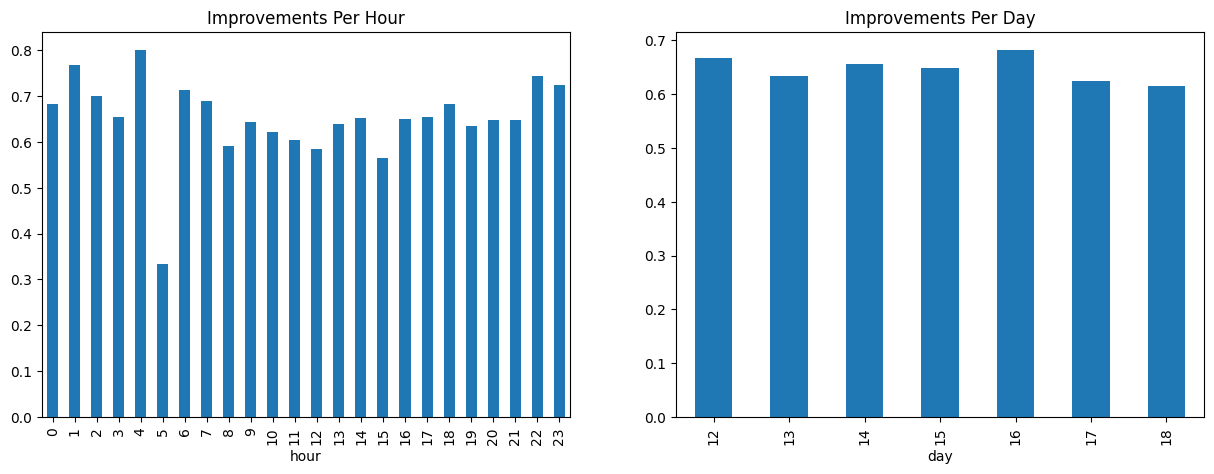

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
test_data.groupby('hour')['better_than_avg'].mean().plot(kind='bar')
plt.title('Improvements per hour')
plt.subplot(1, 2, 2)
test_data.groupby('day')['better_than_avg'].mean().plot(kind='bar')
plt.title('Improvements per day')
plt.show()

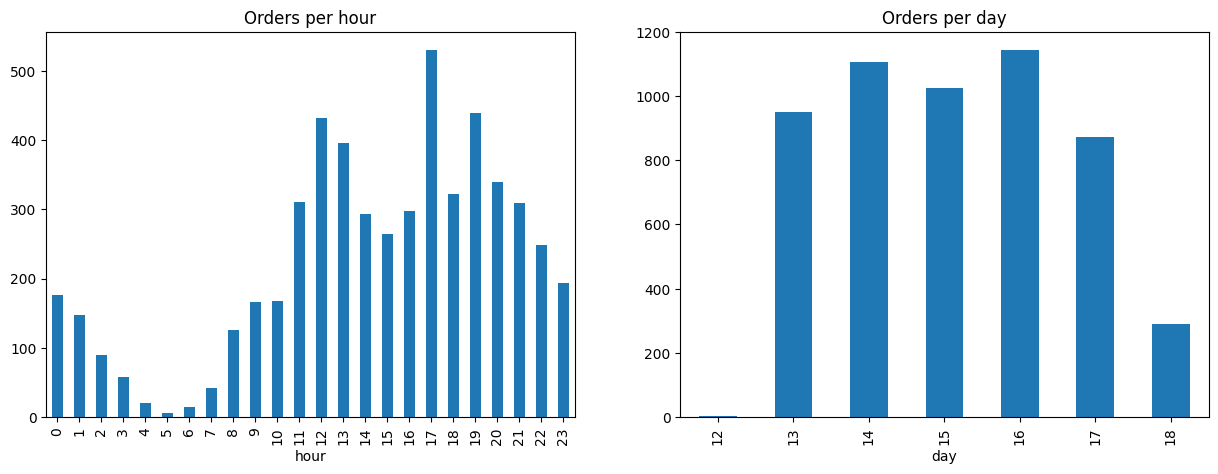

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
test_data['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Orders per hour')
plt.subplot(1, 2, 2)
test_data['day'].value_counts().sort_index().plot(kind='bar')
plt.title('Orders per day')
plt.show()

In [18]:
all_fleets = test_data['fleets'].str.split(',').explode().str.strip()
unique_fleets = all_fleets.unique().tolist()
print(len(unique_fleets))
print(unique_fleets)


9
['SF_Downtown', 'QS_Businessbay', 'Businessbay', 'QS_Exectower', 'Karama', 'Marina', 'Alqouz', 'Motorcity', 'nn_QS_Alquoz']


In [19]:
test_data_by_fleets = test_data.copy()
test_data_by_fleets['fleets'] = test_data_by_fleets['fleets'].str.split(',')
test_data_by_fleets = test_data_by_fleets.explode('fleets')
test_data_by_fleets['fleets'] = test_data_by_fleets['fleets'].str.strip()

test_data_by_fleets.groupby('fleets')['better_than_avg'].mean().sort_values(ascending=False)

fleets
nn_QS_Alquoz      1.000000
Marina            0.700000
Karama            0.651867
Businessbay       0.649453
SF_Downtown       0.648914
Alqouz            0.632184
QS_Exectower      0.602597
QS_Businessbay    0.553571
Motorcity         0.416667
Name: better_than_avg, dtype: float64

In [20]:
print('count of orders per fleet along witht the improvement rate: ')
test_data_by_fleets.groupby('fleets')['better_than_avg'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

count of orders per fleet along witht the improvement rate: 


,count,mean
fleets,,
nn_QS_Alquoz,1,1.000000
Marina,10,0.700000
Karama,991,0.651867
Businessbay,4202,0.649453
SF_Downtown,5389,0.648914
Alqouz,174,0.632184
QS_Exectower,385,0.602597
QS_Businessbay,56,0.553571
Motorcity,12,0.416667


In [21]:
# how come all orders have SF_Downtown in their fleets and most of them also have Businessbay?
print(test_data[test_data['fleets'].str.contains('SF_Downtown')].shape[0])
print(test_data[test_data['fleets'].str.contains('Businessbay')].shape[0])

5389
4202


<hr>
<div style="color: gray; font-style: italic;">🚧🔧 CONT. addresses, lat and lon</div>

In [22]:
# does this make sense? and are these pairs the actual parking locations or the suggested by us?
# would make sense if they are suggested not actual
# could make sense if they are actual but their radius is big enough to include all the parking spots in one parking location
print('Improvement per location:')
test_data.groupby(['p_lat', 'p_lng'])['better_than_avg'].mean().sort_values(ascending=False)

Improvement per location:


p_lat      p_lng    
25.207665  55.251805    1.00
25.203874  55.277410    1.00
25.173221  55.237890    1.00
25.177992  55.267552    1.00
25.177200  55.247624    1.00
                        ... 
25.178138  55.267297    0.25
25.176569  55.245090    0.00
25.202153  55.272572    0.00
25.180101  55.246638    0.00
25.173140  55.237988    0.00
Name: better_than_avg, Length: 257, dtype: float64

In [23]:
print("Number of addresses per improvement:")
test_data.groupby('dst_address_code')['better_than_avg'].mean().value_counts()
#test_data.groupby('dst_address_code')['better_than_avg'].agg(['count', 'mean']).sort_values(by='mean', ascending=False).value_counts()

Number of addresses per improvement:


better_than_avg
1.000000    1074
0.000000     462
0.500000     278
0.666667     157
0.333333      76
0.750000      72
0.600000      35
0.250000      31
0.800000      27
0.400000      17
0.833333      14
0.857143      12
0.200000       9
0.625000       9
0.714286       8
0.285714       6
0.428571       4
0.571429       3
0.777778       3
0.636364       3
0.900000       2
0.888889       1
0.812500       1
0.875000       1
0.818182       1
0.363636       1
0.166667       1
0.375000       1
0.444444       1
0.615385       1
0.384615       1
Name: count, dtype: int64

In [24]:
# get the top 50 dst_address_code with the most improvements and see if they could be clustered together based on their lat and lng
# need to set a radius for the clustering
# re check AQ's doc
test_data.groupby('dst_address_code')['better_than_avg'].mean().sort_values(ascending=False).head(461)

dst_address_code
addr::noon_customer::ae::ff927b8de2f52b894cb3bdd3548225b9::5     1.0
addr::noon_customer::ae::ff8274f5de8a43aef5059570a1c7ede0::2     1.0
addr::noon_customer::ae::0077c23430a64d4558a3ce9b500ce66e::3     1.0
addr::noon_customer::ae::007a4e3a2c44fbaa079ea59a86a510ee::1     1.0
addr::noon_customer::ae::fdf256349a5a099e1f1de1b156894728::5     1.0
                                                                ... 
addr::noon_customer::ae::334395156b8a3eea7233ed7f2980ee79::2     1.0
addr::noon_customer::ae::32e19e519fea930e462fcb4a61b25aae::1     1.0
addr::noon_customer::ae::32d2d5749800e5f546ba1db25bb49d81::10    1.0
addr::noon_customer::ae::327b1286397104364d703f6f5e7a71fc::2     1.0
addr::noon_customer::ae::32246dbe111356c6291aa2b39aabb3b3::3     1.0
Name: better_than_avg, Length: 461, dtype: float64

In [ ]:
heat_data = test_data.dropna(subset=['p_lat', 'p_lng', 'reversed_deviation']).copy()
scaler = MinMaxScaler()
heat_data['weight'] = scaler.fit_transform(heat_data[['reversed_deviation']])

heat_data_list = heat_data[['p_lat', 'p_lng', 'weight']].values.tolist()
map_center = [25.2048, 55.2708]
m = folium.Map(location=map_center, zoom_start=10)
HeatMap(heat_data_list, radius=10).add_to(m)
m.save("uae_impact_heatmap.html")

In [47]:
m

<hr>
<div style="color: gray; font-style: italic;">🔚 End of addresses</div>

In [ ]:
grouped = test_data.groupby('dst_address_code')[['avg_address_handover_last_3_months', 'median_address_handover_last_3_months']].first()

median_gt_avg = grouped[grouped['median_address_handover_last_3_months'] > grouped['avg_address_handover_last_3_months']]
avg_gt_median = grouped[grouped['median_address_handover_last_3_months'] < grouped['avg_address_handover_last_3_months']]

print(f"Number of addresses with median > avg: {median_gt_avg.shape[0]}")
print(f"Number of addresses with avg > median: {avg_gt_median.shape[0]}")

# Do we need more rows than just 3 mothns? or are the values consistent before that any way?

Number of addresses with median > avg: 328
Number of addresses with avg > median: 1961


# Discuss

In [ ]:
# avg in tasks != avg in addresses nor median in addresses
tasks_1000 = pd.read_csv('task_1000_data.csv', index_col=0)
addresses = pd.read_csv('address_data.csv', index_col=0)
test_data = tasks_1000.join(addresses, on='dst_address_code', how='inner', lsuffix='_tasks', rsuffix='_addresses')
print((test_data['avg_handover_last_3_months_tasks'] == test_data['avg_handover_last_3_months_addresses']).value_counts())
print((test_data['avg_handover_last_3_months_tasks'] == test_data['median_handover_last_3_months']).value_counts())
test_data[test_data['avg_handover_last_3_months_tasks'] != test_data['avg_handover_last_3_months_addresses']]

False    971
True      64
Name: count, dtype: int64
False    1035
Name: count, dtype: int64


,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,reasons,p_lat_tasks,...,why,is_parking_accurate,time_in_dubai,hour,day,is_weekend,p_lat_addresses,p_lng_addresses,avg_handover_last_3_months_addresses,median_handover_last_3_months
id_task,,,,,,,,,,,,,,,,,,,,,
60170297.0,2025-03-13 12:38:15.000000 UTC,NNF3DNN3FSELWJYA,406.0,2566.0,1785.0,3.0,addr::noon_customer::ae::80fa2c3ebc879d6f0bcd6...,"QS_Exectower,SF_Downtown,Businessbay","forgot_to_mark_delivered,forgot_to_mark_delive...",25.190008,...,NaN,NaN,2025-03-13 16:38,16.0,13.0,False,25.190008,55.263444,340.750000,269.0
60200190.0,2025-03-13 16:28:04.000000 UTC,FF3DNN3RA6KIRQA,110.0,2433.0,1370.0,0.0,addr::noon_customer::ae::b7db816ba226a8e662d24...,"Businessbay,SF_Downtown",NaN,25.176937,...,NaN,NaN,2025-03-13 20:28,20.0,13.0,False,25.176937,55.270768,150.965517,145.0
60200801.0,2025-03-13 16:34:11.000000 UTC,FF3DNN6V8034ZPA,65.0,2274.0,687.0,0.0,addr::noon_customer::ae::590b570c48f7eb264f683...,"Businessbay,SF_Downtown",NaN,25.180026,...,NaN,NaN,2025-03-13 20:34,20.0,13.0,False,25.180026,55.265976,170.518518,154.0
60144702.0,2025-03-13 04:58:44.000000 UTC,FF3DNNW6JTZX55A,171.0,2105.0,1232.0,0.0,addr::noon_customer::ae::86974a8440f1bf8c3b209...,"Businessbay,SF_Downtown",NaN,25.175128,...,NaN,NaN,2025-03-13 8:58,8.0,13.0,False,25.175128,55.309065,227.294118,225.0
60191382.0,2025-03-13 15:08:44.000000 UTC,FF3DNNPNZZCVROA,452.0,2129.0,1441.0,2.0,addr::noon_customer::ae::ae79e0ab559002cf3f812...,"Businessbay,SF_Downtown","entry_not_allowed,entry_not_allowed",25.190447,...,NaN,NaN,2025-03-13 19:8,19.0,13.0,False,25.190447,55.281143,255.086957,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60154481.0,2025-03-13 08:52:58.000000 UTC,FF3DNNGV4D2F1PA,386.0,1991.0,822.0,2.0,addr::noon_customer::ae::fae9358ca361401e9b0cc...,"SF_Downtown,Businessbay","entry_not_allowed,entry_not_allowed",25.187555,...,NaN,NaN,NaN,NaN,NaN,NaN,25.187555,55.261026,486.900000,390.0
60158335.0,2025-03-13 09:50:01.000000 UTC,FF3DNNYR5TYN1DA,289.0,3344.0,1117.0,0.0,addr::noon_customer::ae::f199047353ac8adab4313...,"SF_Downtown,Karama",NaN,25.202900,...,NaN,NaN,NaN,NaN,NaN,NaN,25.202900,55.281388,429.700000,409.5
60209340.0,2025-03-13 17:57:10.000000 UTC,FF3DNN06D1B653A,525.0,2272.0,1334.0,2.0,addr::noon_customer::ae::f3dff9fce5f841ee45634...,"Businessbay,SF_Downtown","entry_not_allowed,entry_not_allowed",25.188730,...,NaN,NaN,NaN,NaN,NaN,NaN,25.188730,55.260381,352.181818,267.0


# misc

In [ ]:
test_data.drop(columns=['avg_address_handover_last_3_months_addresses'], inplace=True)
test_data.rename(columns={'avg_address_handover_last_3_months_tasks': 'avg_address_handover_last_3_months'}, inplace=True)
test_data

In [39]:
(test_data['median_address_handover_last3months'] == test_data['median_handover_last_3_months']).value_counts()

True    5418
Name: count, dtype: int64

In [40]:
test_data.drop(columns=['median_handover_last_3_months'], inplace=True)

In [41]:
test_data['median_deviation'] = test_data['handover_time_seconds'] - test_data['median_address_handover_last3months']
(test_data['median_deviation'] == test_data['temp_median_deviation']).value_counts()

False    5401
True       17
Name: count, dtype: int64